In [1]:
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
style.use('ggplot')
# style.use('seaborn-poster') #sets the size of the charts

import os 
import pandas as pd
from tqdm import tqdm
import numpy as np
import sys
import re
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, \
                            precision_score, recall_score, auc, roc_auc_score, \
                            confusion_matrix, roc_curve
from utils.print_pretty_confusion_matrix import plot_confusion_matrix_from_data , pretty_plot_confusion_matrix
sys.path.insert(0, 'dataloaders/')
from ast import literal_eval

from binary_data_loader import LAD_MPR_Loader

In [9]:
data_split = 'train'
model_name =  'retrained_resnet18_balanced_data_without_25_text_removed_medium_aug'#'retrained_resnet18_balanced_data_without_25' #'retrained_resnet18_balanced_data_without_25_text_removed'

p = 'prediction_results/{}/{}/'.format(model_name, data_split)
p_data = 'data/binary_classification_only_lad/'

data_df = pd.read_csv(os.path.join(p_data, 'train_without_25_text_removed.csv')) # 'test_without_25.csv'))
preds_df = pd.read_csv(os.path.join(p, '{}.csv'.format(data_split)))

labels = preds_df['LABELS'].values
preds = preds_df['PREDS'].values
probas = preds_df['PREDS_PROBAS'].values

In [10]:
preds_df.columns

Index(['Unnamed: 0', 'IMG_NAME', 'LABELS', 'PATIENT_NAME', 'PREDS',
       'PREDS_PROBAS', 'STENOSIS_SCORE'],
      dtype='object')

In [11]:
# Check if data corresponds to the saved predictions
assert sum(data_df['LABEL'] == labels) == len(labels)

In [12]:
preds_df.groupby('STENOSIS_SCORE').sum()

,Unnamed: 0,LABELS,PREDS
STENOSIS_SCORE,,,
-25-50%,140369,17,13
-___25%___NORMAL,69972,0,4
-___25-50%___-,395080,17,17
-___>90%___>50%,104023,17,17
-___NORMAL___NORMAL,318104,0,0
25%,5353300,0,152
25%___25%___25%,1407498,0,14
25%___25%___25-50%,611252,34,32
25%___25%___NORMAL,1248072,0,28


In [13]:
s = preds_df['STENOSIS_SCORE'].values
# s = [max([int(i) for i in ' '.join(re.sub('[^A-Za-z0-9]+', ' ', el).split('___')).replace('NORMAL', '0').split()]) for el in s]

In [14]:
temp = [' '.join(re.sub('[>,%<]', ' ', el).split('___')).replace('NORMAL', '0').split() for el in s]
d = {'0':1, '25':2, '25-50':3, '50':4,'50-70':5, '70':6}
temp = [max([d[i] for i in t ]) for t in temp]
s = [list(d.keys())[list(d.values()).index(el)] for el in temp]

KeyError: '-'

In [15]:
preds_df['STENOSIS'] = s

In [16]:
preds_df.groupby('STENOSIS').sum()

,Unnamed: 0,LABELS,PREDS
STENOSIS,,,
-25-50%,140369,17,13
-___25%___NORMAL,69972,0,4
-___25-50%___-,395080,17,17
-___>90%___>50%,104023,17,17
-___NORMAL___NORMAL,318104,0,0
25%,5353300,0,152
25%___25%___25%,1407498,0,14
25%___25%___25-50%,611252,34,32
25%___25%___NORMAL,1248072,0,28


# Results visualization

In [17]:
def estimate_model(y_true, y_pred, pred_probas):
    """
    Calculated all main metrics for binary classification:
        - accuracy, 
        - balanced_accuracy, 
        - precision, 
        - recall, 
        - f1, 
        - roc_auc_score
    Returns:
        - dict: dictionary, key - is the name of metric, value - it`s value=)  
    """
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, pred_probas)
    return {'accuracy': accuracy , 'balanced_accuracy': balanced_accuracy, 'precision': precision, 'recall': recall, 
            'f1': f1, 'roc_auc': roc_auc}


def show_estimate_model_auc(calculated_metrics_dict, color_palette="muted"):
    """
    Plots barplot of the metrics of the model
    
    Args:
        - model_calculated_metrics(dict): dictionary, key - is the name of metric, value - it`s value=)  
    """
    
    # Make a fake dataset
    height = [calculated_metrics_dict['accuracy']]
    bars = ("Accuracy")
    y_pos = np.arange(1)
    print
    plt.figure(figsize=(20,10))
    plt.bar(y_pos, height, color=sns.color_palette(color_palette))
    plt.xticks(y_pos, bars, rotation=0, fontsize=20)
    plt.ylim(0,1)
    plt.yticks(list(plt.yticks()[0]) + [0.5, 0.7, 0.9, 0.1, 0.3], fontsize=20)

    for i in range(len(y_pos)) :
        plt.text(i - 0.22, height[i]+0.03, str(round(height[i], 3)), color='#696969', fontweight='bold', fontsize=22)
    
    plt.ylabel('Metric\'s value', fontsize=30)
    plt.show()


def show_estimate_model(calculated_metrics_dict, color_palette="muted"):
    """
    Plots barplot of the metrics of the model
    
    Args:
        - model_calculated_metrics(dict): dictionary, key - is the name of metric, value - it`s value=)  
    """
    
    # Make a fake dataset
    height = [calculated_metrics_dict['accuracy'], calculated_metrics_dict['balanced_accuracy'], 
              calculated_metrics_dict['precision'], calculated_metrics_dict['recall'], calculated_metrics_dict['f1'], 
              calculated_metrics_dict['roc_auc']]
    bars = ("Accuracy", "Balanced accuracy", "Precision", "Recall", "F1", "ROC/AUC score")
    y_pos = np.arange(len(bars))
    print
    plt.figure(figsize=(20,10))
    plt.bar(y_pos, height, color=sns.color_palette(color_palette))
    plt.xticks(y_pos, bars, rotation=0, fontsize=20)
    plt.ylim(0,1)
    plt.yticks(list(plt.yticks()[0]) + [0.5, 0.7, 0.9, 0.1, 0.3], fontsize=20)

    for i in range(len(y_pos)) :
        plt.text(i - 0.22, height[i]+0.03, str(round(height[i], 3)), color='#696969', fontweight='bold', fontsize=22)
    
    plt.ylabel('Metric\'s value', fontsize=30)
    plt.show()
    
def show_bars(list_values, list_names, size_sections, name_metric, color_palette="muted"):
    y_pos = np.arange(len(list_names))
    print
    plt.figure(figsize=(12,6))
    plt.bar(y_pos, list_values, color=sns.color_palette(color_palette))
    plt.xticks(y_pos, list_names, rotation=0, fontsize=20)
    plt.ylim(0,1)
    plt.yticks(list(plt.yticks()[0]) + [0.5, 0.7, 0.9, 0.1, 0.3], fontsize=20)

    for i in range(len(y_pos)) :
        plt.text(i - 0.22, list_values[i]+0.03, str(round(list_values[i], 3)) +' (' + str(size_sections[i])+ ')', color='#696969', fontweight='bold', fontsize=14)

    plt.ylabel(name_metric, fontsize=30)
    plt.show()
    
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [18]:
all_probas = [[float(el) for el in arr[1:-1].split(' ') if len(el)>2] for arr in probas]

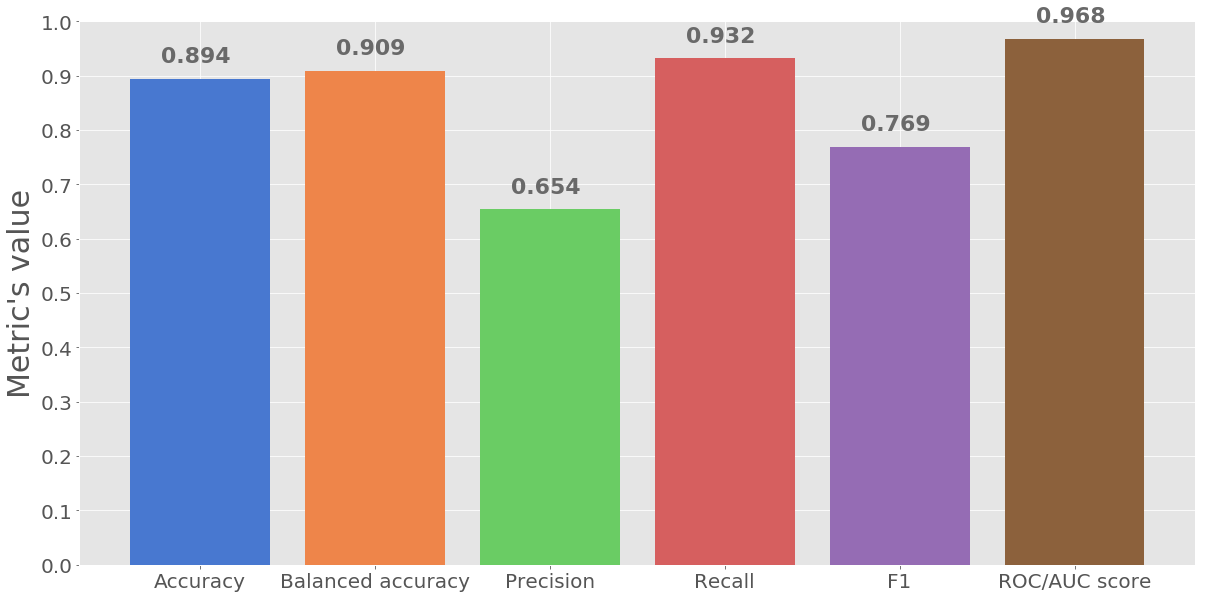

In [19]:
calculated_metrics_dict = estimate_model(labels, preds, [x[1] for x in all_probas])
show_estimate_model(calculated_metrics_dict)

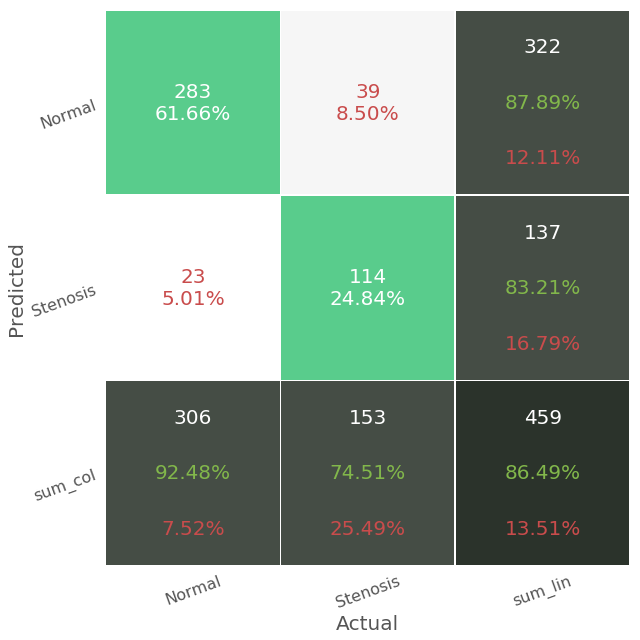

In [12]:
plot_confusion_matrix_from_data(labels, preds, columns=['Normal', 'Stenosis' ],
                               annot=True, cmap='binary', fz=20, figsize=[9,9], show_null_values=0)

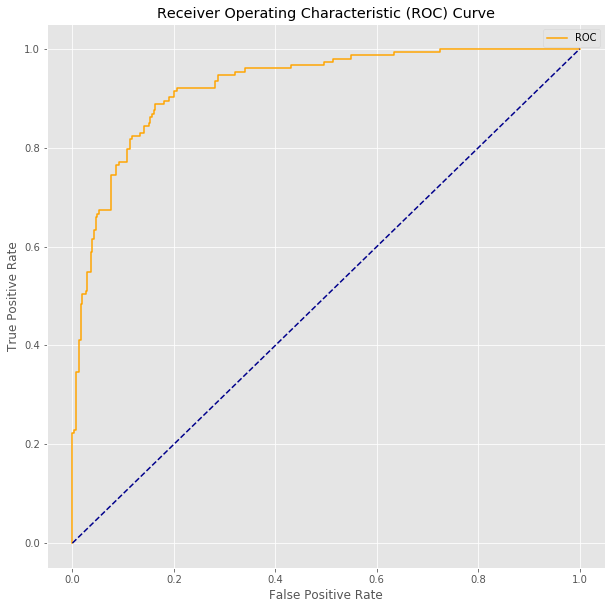

In [14]:
fpr, tpr, thresholds = roc_curve(labels,  [x[1] for x in all_probas ])  
plot_roc_curve(fpr, tpr)

# ERROR EXPLORATION

### According to stages

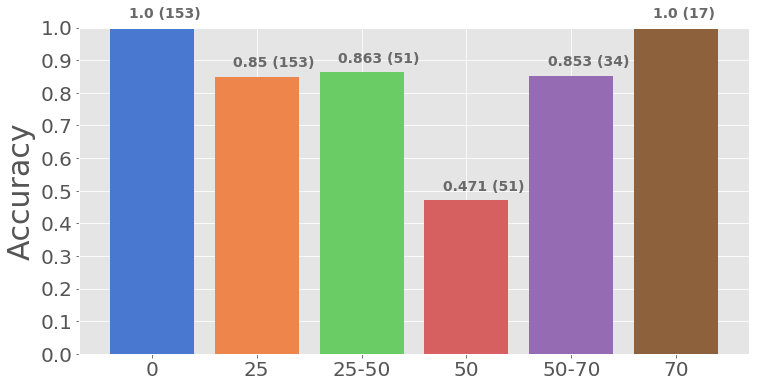

In [15]:
list_accuracies, size_stages = [], []
list_stages = ['0', '25', '25-50', '50', '50-70', '70']

for stenosis_stage in list_stages:
    stage_df = preds_df[preds_df['STENOSIS']==stenosis_stage]

    labels_stage = stage_df['LABELS'].values
    preds_stage = stage_df['PREDS'].values
    probas_stage = stage_df['PREDS_PROBAS'].values
    new_probas_stage = [[float(el) for el in arr[1:-1].split(' ') if len(el)>2] for arr in probas_stage]

    accuracy = accuracy_score(labels_stage, preds_stage)
    list_accuracies.append(accuracy), size_stages.append(len(stage_df))
show_bars(list_accuracies, list_stages, size_stages, 'Accuracy')

### According to sections

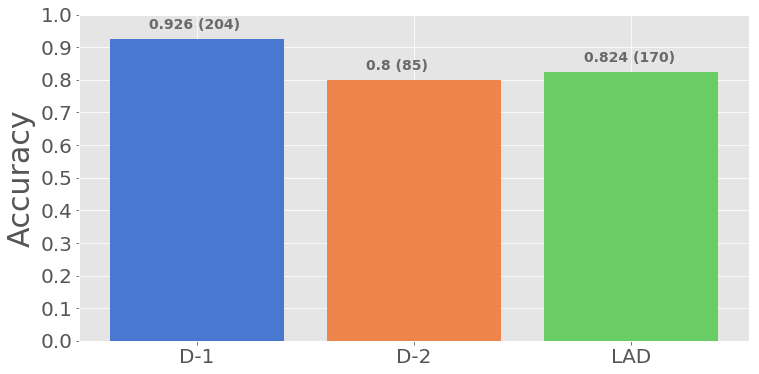

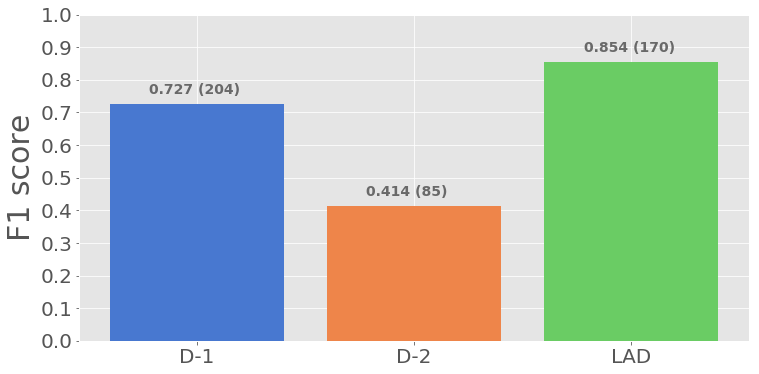

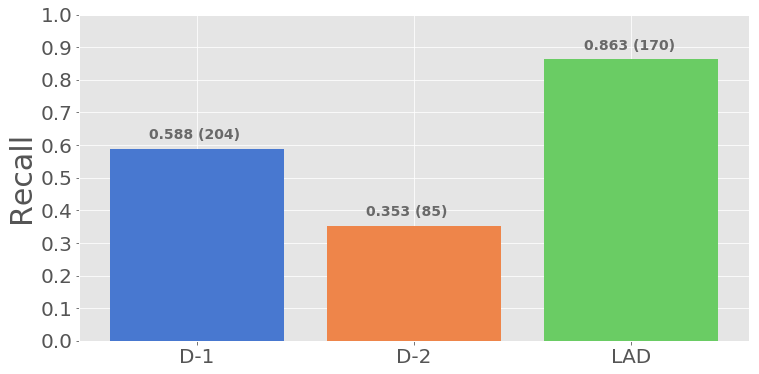

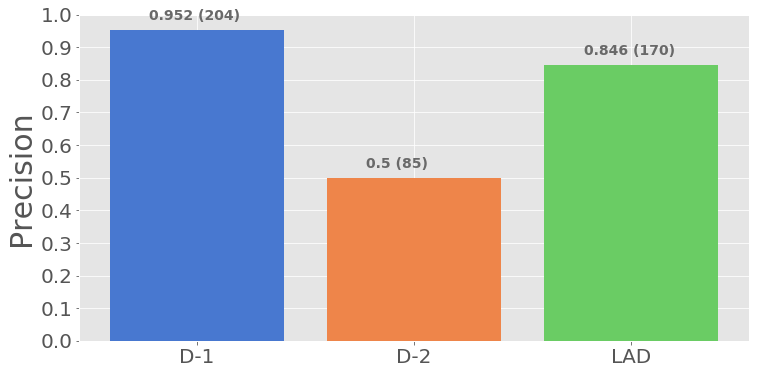

In [16]:
list_accuracies,list_f1,list_recall, list_precision, size_sec = [], [], [], [], []
list_sections = preds_df['IMG_NAME'].apply(lambda x: x.split('_')[0]).unique()

for section in list_sections:
    sec_df = preds_df[preds_df['IMG_NAME'].str.contains(section)]

    labels_sec = sec_df['LABELS'].values
    preds_sec = sec_df['PREDS'].values
    probas_sec = sec_df['PREDS_PROBAS'].values
    new_probas_sec = [[float(el) for el in arr[1:-1].split(' ') if len(el)>2] for arr in probas_stage]

    accuracy = accuracy_score(labels_sec, preds_sec)
    f1 = f1_score(labels_sec, preds_sec)
    recall = recall_score(labels_sec, preds_sec)
    precision = precision_score(labels_sec, preds_sec)
    list_accuracies.append(accuracy), size_sec.append(len(sec_df)), list_f1.append(f1), list_recall.append(recall), list_precision.append(precision)
    
show_bars(list_accuracies, list_sections, size_sec, 'Accuracy')
show_bars(list_f1, list_sections, size_sec, 'F1 score')
show_bars(list_recall, list_sections, size_sec, 'Recall')
show_bars(list_precision, list_sections, size_sec, 'Precision')


plt.show()

## Check data for class balance

In [17]:
preds_df[['LABELS', 'PREDS']].groupby('LABELS').sum().join(preds_df.groupby('LABELS')['Unnamed: 0'].count())

,PREDS,Unnamed: 0
LABELS,,
0,23,306
1,114,153


In [20]:
data_split = 'val' 
model_name = 'retrained_resnet18_balanced_data_without_25_text_removed'

p = 'prediction_results/{}/{}/'.format(model_name, data_split)
data_df = pd.read_csv(os.path.join(p_data, 'val_without_25_text_removed.csv'))
preds_df_val = pd.read_csv(os.path.join(p, '{}.csv'.format(data_split)))

preds_df_val[['LABELS', 'PREDS']].groupby('LABELS').sum().join(preds_df_val.groupby('LABELS')['Unnamed: 0'].count())

,PREDS,Unnamed: 0
LABELS,,
0,18,255
1,92,119


In [21]:
data_split = 'train'
model_name = 'retrained_resnet18_balanced_data_without_25_text_removed'

p = 'prediction_results/{}/{}/'.format(model_name, data_split)
data_df = pd.read_csv(os.path.join(p_data, 'train_without_25_text_removed.csv'))
preds_df_train = pd.read_csv(os.path.join(p, '{}.csv'.format(data_split)))

preds_df_train[['LABELS', 'PREDS']].groupby('LABELS').sum().join(preds_df_train.groupby('LABELS')['Unnamed: 0'].count())

,PREDS,Unnamed: 0
LABELS,,
0,5,21339
1,4980,4980


# Calculate accuracy grouped by patient

In [22]:
preds_df['PATIENT_ID'] = preds_df['IMG_NAME'].apply(lambda x: x.split('_')[2])
preds_df['SECTION'] = preds_df['IMG_NAME'].apply(lambda x: x.split('_')[0])

patients_ids = preds_df['PATIENT_ID'].unique()
sections_ids = preds_df['SECTION'].unique()

In [23]:
preds_df.groupby(['PATIENT_ID', 'SECTION']).count()['PREDS']

PATIENT_ID       SECTION
CTCAPHD16081938  D-1        17
                 LAD        17
CTCASIP30041975  D-1        17
                 D-2        17
                 LAD        17
CTCASTR17021954  D-1        17
CTCASTS01111969  D-1        17
                 LAD        17
CTCASTW15121946  LAD        17
CTCATHJ17011957  D-1        17
                 LAD        17
CTCATKR01031953  D-1        17
                 D-2        17
                 LAD        17
CTCAVAH09071948  D-1        17
                 LAD        17
CTCAWUK05041963  D-1        17
CTCAYOA13121966  D-1        17
                 D-2        17
CTCAYOG08091955  D-1        17
                 D-2        17
                 LAD        17
CTCAZDV13081958  D-1        17
                 D-2        17
                 LAD        17
CTCAZHX30011957  D-1        17
                 LAD        17
Name: PREDS, dtype: int64

In [30]:
patients_auc = {}
patients_df = preds_df[['LABELS', 'PREDS', 'PATIENT_ID', 'SECTION']].groupby(['PATIENT_ID', 'SECTION'], as_index=False).count()[['PATIENT_ID', 'SECTION']]
patients_df['AUC'] = None

for p in patients_ids:
    sections_dict = {}
    for s in sections_ids:
        temp_df = preds_df[preds_df['PATIENT_ID'] == p][preds_df['SECTION'] == s]
        temp_pat = patients_df[patients_df['PATIENT_ID']==p][patients_df['SECTION']==s]
        if len(temp_df) > 0:
            acc_patient_section = accuracy_score(temp_df['LABELS'], temp_df['PREDS'])
            sections_dict[s] = acc_patient_section
            patients_df.xs(temp_pat.index[0])['AUC'] = float(acc_patient_section)
    patients_auc[p] = sections_dict
patients_df['AUC'] = patients_df['AUC'].astype(float)

/home/dobko/env/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/dobko/env/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [33]:
preds_df[['LABELS', 'PREDS', 'PATIENT_ID', 'SECTION']].groupby(['PATIENT_ID', 'SECTION'], as_index=False).sum()

,PATIENT_ID,SECTION,LABELS,PREDS
0,CTCAPHD16081938,D-1,0,1
1,CTCAPHD16081938,LAD,0,10
2,CTCASIP30041975,D-1,0,0
3,CTCASIP30041975,D-2,0,6
4,CTCASIP30041975,LAD,17,17
5,CTCASTR17021954,D-1,0,0
6,CTCASTS01111969,D-1,0,0
7,CTCASTS01111969,LAD,17,11
8,CTCASTW15121946,LAD,17,17
9,CTCATHJ17011957,D-1,0,0


In [31]:
patients_df

,PATIENT_ID,SECTION,AUC
0,CTCAPHD16081938,D-1,0.941176
1,CTCAPHD16081938,LAD,0.411765
2,CTCASIP30041975,D-1,1.000000
3,CTCASIP30041975,D-2,0.647059
4,CTCASIP30041975,LAD,1.000000
5,CTCASTR17021954,D-1,1.000000
6,CTCASTS01111969,D-1,1.000000
7,CTCASTS01111969,LAD,0.647059
8,CTCASTW15121946,LAD,1.000000
9,CTCATHJ17011957,D-1,1.000000


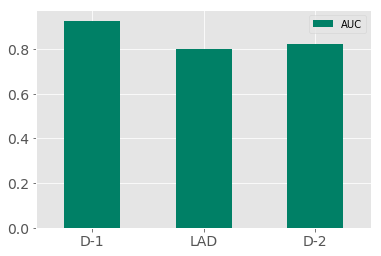

In [26]:
mean_sections = patients_df[['SECTION', 'AUC']].groupby('SECTION', as_index=False).mean()
mean_sections = mean_sections.set_index(patients_df['SECTION'].unique())
del mean_sections['SECTION']
mean_sections.plot(kind='bar', colormap='summer', fontsize=14, rot=0)

In [84]:
patients_df[['PATIENT_ID', 'AUC']].groupby('PATIENT_ID').mean()

,AUC
PATIENT_ID,
CTCAPHD16081938,0.676471
CTCASIP30041975,0.882353
CTCASTR17021954,1.000000
CTCASTS01111969,0.823529
CTCASTW15121946,1.000000
CTCATHJ17011957,0.823529
CTCATKR01031953,0.666667
CTCAVAH09071948,0.882353
CTCAWUK05041963,1.000000
